<a href="https://colab.research.google.com/github/surajun/Deepfakeimage/blob/main/8octAudio_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gdown librosa tensorflow tqdm

In [ ]:
file_id = "19Trqpf5qlK9TcASDlhu2Vle_P1-ZhSkr"  # your dataset file ID
!gdown --id {file_id} -O /content/audio_dataset.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19Trqpf5qlK9TcASDlhu2Vle_P1-ZhSkr
From (redirected): https://drive.google.com/uc?id=19Trqpf5qlK9TcASDlhu2Vle_P1-ZhSkr&confirm=t&uuid=61a392ad-c254-47c7-8188-4fe9f159b908
To: /content/audio_dataset.zip
100% 5.77G/5.77G [01:18<00:00, 73.0MB/s]


In [ ]:
!unzip -q /content/audio_dataset.zip -d /content/audio_dataset

In [ ]:
!ls /content/audio_dataset

dev  eval  README.txt  train


In [ ]:
# STEP 5: Feature extraction and dataset creation
# ===============================================
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm

def extract_features(file_path, sr=16000, n_mfcc=40):
    try:
        audio, _ = librosa.load(file_path, sr=sr)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        return mfccs_scaled
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def prepare_dataset(root_dir):
    X, y = [], []
    for label in ["real", "fake", "bonafide", "spoof"]:  # supports common naming
        folder = os.path.join(root_dir, label)
        if not os.path.exists(folder):
            continue
        print(f"Processing {label} samples...")
        for fname in tqdm(os.listdir(folder)):
            if fname.lower().endswith(('.wav', '.flac', '.mp3')):
                path = os.path.join(folder, fname)
                feats = extract_features(path)
                if feats is not None:
                    X.append(feats)
                    y.append(0 if label in ["real", "bonafide"] else 1)
    return np.array(X), np.array(y)

In [ ]:
# STEP 6: Load and prepare data
# ===============================================
dataset_root = "/content/audio_dataset/train"
X, y = prepare_dataset(dataset_root)
print("✅ Data Loaded — Feature shape:", X.shape, "Labels:", len(y))

Processing real samples...


100%|██████████| 2525/2525 [00:38<00:00, 65.96it/s]


Processing fake samples...


100%|██████████| 10660/10660 [01:35<00:00, 111.13it/s]

✅ Data Loaded — Feature shape: (13185, 40) Labels: 13185


In [ ]:
# STEP 7: Split data
# ===============================================
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0], "Validation samples:", X_val.shape[0])

Training samples: 10548 Validation samples: 2637


In [ ]:
# STEP 8: Build lightweight model
# ===============================================
input_dim = X_train.shape[1]
model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,521 (170.00 KB)

 Trainable params: 43,521 (170.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# STEP 9: Train model
# ===============================================
checkpoint = ModelCheckpoint("audio_model.keras", monitor='val_accuracy', save_best_only=True, mode='max')

# Moderate epochs for Colab (fast but effective)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,             # 👈 balanced to avoid long training
    batch_size=32,
    callbacks=[checkpoint],
    verbose=1
)


Epoch 1/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7589 - loss: 2.7053 - val_accuracy: 0.9230 - val_loss: 0.2749
Epoch 2/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9014 - loss: 0.2442 - val_accuracy: 0.9636 - val_loss: 0.1112
Epoch 3/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9479 - loss: 0.1232 - val_accuracy: 0.9735 - val_loss: 0.0686
Epoch 4/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9646 - loss: 0.0913 - val_accuracy: 0.9807 - val_loss: 0.0464
Epoch 5/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9734 - loss: 0.0688 - val_accuracy: 0.9845 - val_loss: 0.0408
Epoch 6/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9780 - loss: 0.0628 - val_accuracy: 0.9875 - val_loss: 0.0375
Epoch 7/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9789 - loss: 0.0556 - val_accuracy: 0.9894 - val_loss: 0.0299
Epoch 8/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9858 - loss: 0.0397 - val_accuracy: 0

In [ ]:
# ===============================================
# STEP 10: Evaluate & Save model
# ===============================================
loss, acc = model.evaluate(X_val, y_val)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9955 - loss: 0.0197

✅ Validation Accuracy: 99.36%


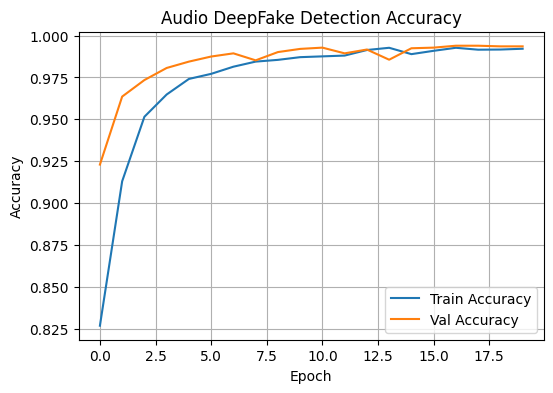

In [ ]:
# STEP 11: Plot accuracy curve (optional)
# ===============================================
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Audio DeepFake Detection Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


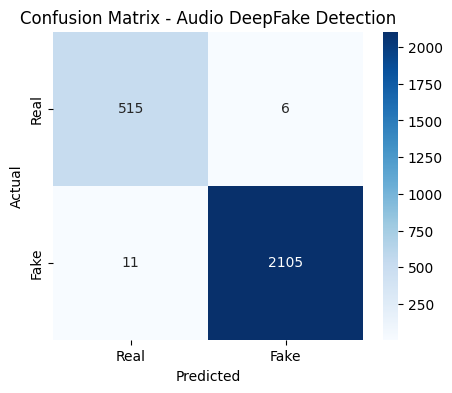


Classification Report:

              precision    recall  f1-score   support

        Real       0.98      0.99      0.98       521
        Fake       1.00      0.99      1.00      2116

    accuracy                           0.99      2637
   macro avg       0.99      0.99      0.99      2637
weighted avg       0.99      0.99      0.99      2637



In [ ]:
# ===============================================
# STEP 12: Confusion Matrix & Classification Report
# ===============================================
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
labels = ['Real', 'Fake']

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Audio DeepFake Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=labels))


In [ ]:
# Create a folder in your Drive (optional)
!mkdir -p /content/drive/MyDrive/DeepFake_Audio_Model

# Copy the trained model to Drive
!cp audio_model.keras /content/drive/MyDrive/DeepFake_Audio_Model/audio_model.keras

print("✅ Model saved to Google Drive at: /MyDrive/DeepFake_Audio_Model/audio_model.keras")


✅ Model saved to Google Drive at: /MyDrive/DeepFake_Audio_Model/audio_model.keras


In [ ]:
import numpy as np

np.save("/content/X_train.npy", X_train)
np.save("/content/y_train.npy", y_train)
np.save("/content/X_val.npy", X_val)
np.save("/content/y_val.npy", y_val)

# Save copies to Google Drive
!cp /content/X_train.npy /content/drive/MyDrive/DeepFake_Audio_Model/
!cp /content/y_train.npy /content/drive/MyDrive/DeepFake_Audio_Model/
!cp /content/X_val.npy /content/drive/MyDrive/DeepFake_Audio_Model/
!cp /content/y_val.npy /content/drive/MyDrive/DeepFake_Audio_Model/

print("✅ Feature data saved to Google Drive.")


✅ Feature data saved to Google Drive.


In [ ]:
import pandas as pd

pd.DataFrame(history.history).to_csv("/content/training_history.csv", index=False)
!cp /content/training_history.csv /content/drive/MyDrive/DeepFake_Audio_Model/
print("✅ Training history saved to Google Drive.")


✅ Training history saved to Google Drive.


In [ ]:
!pip install librosa --upgrade
!pip install resampy soundfile


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.7 MB/s eta 0:00:00


In [ ]:
!pip install resampy


In [ ]:
!pip install librosa --upgrade
!pip install resampy soundfile


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import librosa
from tensorflow.keras.models import load_model
from google.colab import files

# ✅ Load model from Google Drive
model_path = "/content/drive/MyDrive/DeepFake_Audio_Model/audio_model.keras"
model = load_model(model_path)
print("✅ Model loaded successfully!")

# ✅ Upload test audio
uploaded = files.upload()

# ✅ Feature extraction (matching training)
def extract_features_mean(audio_path):
    audio, sample_rate = librosa.load(audio_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_mean = np.mean(mfccs.T, axis=0)  # take mean over time axis
    return mfccs_mean

# ✅ Prediction loop
for file_name in uploaded.keys():
    print(f"\n🎧 Checking file: {file_name}")
    features = extract_features_mean(file_name)
    features = features.reshape(1, -1)  # shape (1, 40)

    prediction = model.predict(features)[0][0]
    confidence = (prediction * 100) if prediction > 0.5 else ((1 - prediction) * 100)

    if prediction > 0.5:
        print(f"🧠 Result: FAKE audio detected ❌ | Confidence: {confidence:.2f}%")
    else:
        print(f"🎤 Result: REAL audio ✅ | Confidence: {confidence:.2f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model loaded successfully!


TypeError: 'NoneType' object is not subscriptable